Import necessary files

In [32]:
from google.colab import drive, files
import os
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
import matplotlib.pyplot as plt
import numpy as np
import cv2
import tensorflow as tf
from keras.layers import Activation, Dropout, Flatten, Dense, BatchNormalization, Input
from keras.models import *
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Input
from keras.layers import Activation, Dropout, Flatten, Dense, BatchNormalization
from keras.optimizers import Adam
from tensorflow.keras.applications.resnet50 import ResNet50

Connect notebook with google drive

In [ ]:
drive.mount('/content/drive/')
os.chdir('/content/drive/My Drive/Kaggle')

Mounted at /content/drive/


Load sample image and then reshape

(345, 461, 3)
(100, 150, 3)


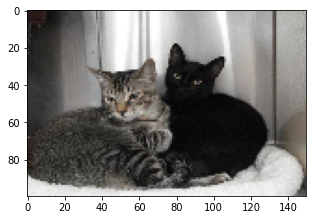

In [ ]:
#get image size from dataset
img = load_img('training_set/training_set/cats/cat.8.jpg')  # this is a PIL image
x = img_to_array(img)
print(x.shape)
plt.figure(figsize=(5,5))
x = cv2.resize(x, (150, 100))
print(x.shape)
plt.imshow(x/255)

Create data generator, auto labelling data based on the folder

In [ ]:
#Use different object for validation so the validation set won't be augmented
train_datagen = ImageDataGenerator( #Some little augmentations
    rescale=1./255,
    rotation_range=0.5, 
    shear_range=0.2,
    validation_split = 0.2, #20% of the data will be used as validation set
    zoom_range=0.3,
)

valid_datagen=ImageDataGenerator(rescale=1./255,validation_split=0.2)

In [ ]:
train_generator = train_datagen.flow_from_directory(
        './training_set/training_set', 
        batch_size=64,
        shuffle=False,
        target_size = (x.shape[0], x.shape[1]),
        class_mode='categorical',
        subset='training')  
        

validation_generator = valid_datagen.flow_from_directory(
        './training_set/training_set', 
        batch_size=64,
        shuffle=False,
        target_size = (x.shape[0], x.shape[1]),
        class_mode='categorical',
        subset='validation')

Found 6404 images belonging to 2 classes.
Found 1601 images belonging to 2 classes.


Modelling, use resnet50 model

In [ ]:
new_input = Input(shape=(x.shape[0], x.shape[1], 3))

In [ ]:
input_shape = (x.shape[0], x.shape[1], 3)

In [ ]:
#Still not talking about our train/test data or any pre-processing.
model = Sequential()

# 1st layer as the lumpsum weights from resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5
# NOTE that this layer will be set below as NOT TRAINABLE, i.e., use it as is
model.add(ResNet50(include_top = False, pooling = 'avg'))

# 2nd layer as Dense for 2-class classification, i.e., dog or cat using SoftMax activation
model.add(Dense(2, activation = 'sigmoid'))

# Say not to train first layer (ResNet) model as it is already trained
model.layers[0].trainable = False

94773248/94765736 [==============================] - 1s 0us/step


In [ ]:
#make model folder model
model._name = "CatNDogs_ResNet"
model_save_path = "./models/"
if not os.path.exists(model_save_path):
    os.mkdir(model_save_path)

Use early stopping and model checkpoint (save the best only)

In [ ]:
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, Callback
checkpoint = ModelCheckpoint(os.path.join(model_save_path, model.name+".h5"), save_weights_only=True,
                             verbose=1, save_best_only=True, monitor='val_accuracy', mode='max')
early_stop = EarlyStopping(patience=7, verbose=1, monitor='val_accuracy', mode='max')

compiling model

In [ ]:
model.compile(optimizer='adam', #Using Adam Optimizer
              loss="binary_crossentropy",   
              metrics=["accuracy"])

Training model

In [18]:
%%time
history = model.fit(
        train_generator,
        validation_data = validation_generator,
        steps_per_epoch = int(train_generator.samples) // 64,
        epochs = 30,
        callbacks=[checkpoint, early_stop])

Epoch 1/30
100/100 [==============================] - 1652s 16s/step - loss: 0.8916 - accuracy: 0.5078 - val_loss: 1.0530 - val_accuracy: 0.5003

Epoch 00001: val_accuracy improved from -inf to 0.50031, saving model to ./models/CatNDogs_ResNet.h5
Epoch 2/30
100/100 [==============================] - 577s 6s/step - loss: 0.8230 - accuracy: 0.5279 - val_loss: 2.3937 - val_accuracy: 0.5003

Epoch 00002: val_accuracy did not improve from 0.50031
Epoch 3/30
100/100 [==============================] - 570s 6s/step - loss: 0.7942 - accuracy: 0.5506 - val_loss: 3.1794 - val_accuracy: 0.5003

Epoch 00003: val_accuracy did not improve from 0.50031
Epoch 4/30
100/100 [==============================] - 592s 6s/step - loss: 0.7716 - accuracy: 0.5740 - val_loss: 1.1018 - val_accuracy: 0.5003

Epoch 00004: val_accuracy did not improve from 0.50031
Epoch 5/30
100/100 [==============================] - 603s 6s/step - loss: 0.7511 - accuracy: 0.5554 - val_loss: 1.2602 - val_accuracy: 0.5003

Epoch 00005:

Plot training result

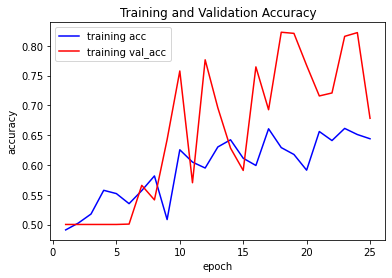

In [20]:
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
epochs = range(1, len(val_acc) + 1)

plt.plot(epochs, acc, color="blue", label="training acc")
plt.plot(epochs, val_acc, color="red", label="training val_acc")
plt.legend()
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.title("Training and Validation Accuracy")
# plt.savefig(f"./balanced/models/{model._name}_f1_training_plot.jpg")
plt.show()

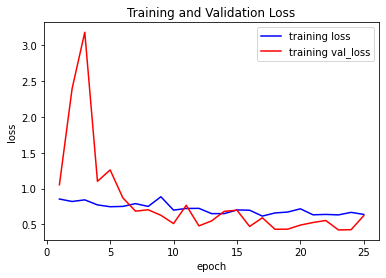

In [21]:
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(val_acc) + 1)

plt.plot(epochs, loss, color="blue", label="training loss")
plt.plot(epochs, val_loss, color="red", label="training val_loss")

plt.legend()
plt.xlabel("epoch")
plt.ylabel("loss")
plt.title("Training and Validation Loss")

plt.show()

Prediction

Saving 67586673.jpg to 67586673 (3).jpg
Hmmm... this is a Cat!


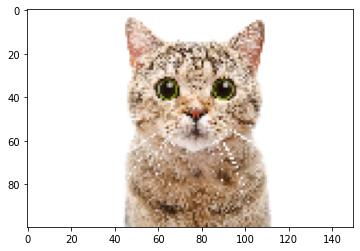

In [33]:

uploaded = files.upload()

filename = list(uploaded.keys())[0]

img = load_img(f"/content/drive/My Drive/Kaggle/{filename}", target_size=(x.shape[0], x.shape[1]))
plt.imshow(img)
img = img_to_array(img)

img = np.expand_dims(img, axis=0)/255

images = np.vstack([img])
classes = model.predict(images)
classes = classes.tolist()[0]
# print(classes)
label = classes.index(max(classes))
# print(label)
if label == 1:
  label = "Dog"
else:
  label = "Cat"

# print(label)

print(f"Hmmm... this is a {label}!")